In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# adfuler checks if data is stationary or non-stationary
from statsmodels.tsa.stattools import adfuller
# from auto_arima we get odrer of p,d,q
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files


uploaded = files.upload()


Saving Airlines+Data.xlsx to Airlines+Data.xlsx


In [3]:
data = pd.read_excel('Airlines+Data.xlsx')
data.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


<Axes: >

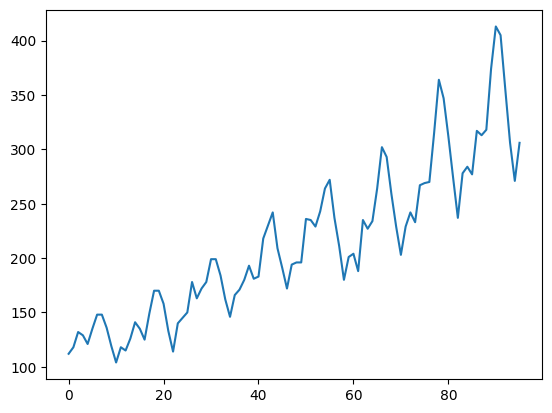

In [4]:
data.Passengers.plot()

In [5]:
# linear upward trend and multiplicative seasonality
# change non-stationary data into stationary data
# data.head()

In [6]:
data.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [7]:
data.shape

(96, 2)

In [8]:
data["Date"] = data["Month"]
data["Year"] = data['Date'].dt.strftime("%y")
data["Month"] = data["Month"].dt.strftime("%b")
data['t'] = data.index+1
data['t_square'] = data['t']**2
data['log_passengers'] = np.log(data['Passengers'])
data = pd.get_dummies(data=data,columns=['Month'])
data.head()

,Passengers,Date,Year,t,t_square,log_passengers,Month_Apr,Month_Aug,Month_Dec,Month_Feb,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,112,1995-01-01,95,1,1,4.718499,0,0,0,0,1,0,0,0,0,0,0,0
1,118,1995-02-01,95,2,4,4.770685,0,0,0,1,0,0,0,0,0,0,0,0
2,132,1995-03-01,95,3,9,4.882802,0,0,0,0,0,0,0,1,0,0,0,0
3,129,1995-04-01,95,4,16,4.859812,1,0,0,0,0,0,0,0,0,0,0,0
4,121,1995-05-01,95,5,25,4.795791,0,0,0,0,0,0,0,0,1,0,0,0


In [9]:
data.shape

(96, 18)

In [10]:
data.dtypes

Passengers                 int64
Date              datetime64[ns]
Year                      object
t                          int64
t_square                   int64
log_passengers           float64
Month_Apr                  uint8
Month_Aug                  uint8
Month_Dec                  uint8
Month_Feb                  uint8
Month_Jan                  uint8
Month_Jul                  uint8
Month_Jun                  uint8
Month_Mar                  uint8
Month_May                  uint8
Month_Nov                  uint8
Month_Oct                  uint8
Month_Sep                  uint8
dtype: object

<Axes: xlabel='Year', ylabel='Passengers'>

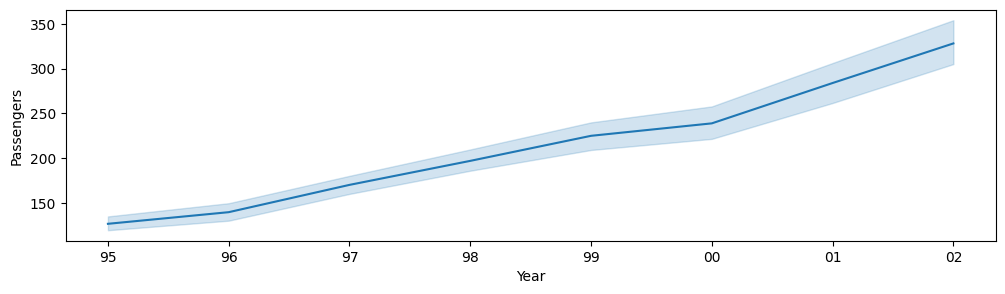

In [11]:
plt.figure(figsize=(12,3))
sns.lineplot(data=data,x='Year',y='Passengers')

### Data Splitting

In [12]:
train = data.head(86)
test = data.tail(10)

### import error function and statistics model

In [13]:
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

### Building different models

#### Linear Model
##### $Y_t = \beta_o+\beta_1t+\epsilon$

In [14]:
linear_model = smf.ols('Passengers~t',data=data).fit()
pred_linear = pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear = np.sqrt(mean_squared_error(test['Passengers'],pred_linear))
rmse_linear

51.93950342982208

#### Exponential model
##### $Log(Y_t) = \beta_0+\beta_1t+\epsilon$

In [15]:
exp_model = smf.ols('log_passengers~t',data=train).fit()
pred_exp = pd.Series(exp_model.predict(pd.DataFrame(test['t'])))
rmse_exp = np.sqrt(mean_squared_error(test['log_passengers'],pred_exp))
rmse_exp

0.14475099238167138

#### Quadratic model
##### $Y_t = \beta_0+\beta_1t+\beta_2t^2+\epsilon$

In [16]:
quad_model = smf.ols('Passengers~t+t_square',data=train).fit()
pred_quad = pd.Series(quad_model.predict(pd.DataFrame(test[['t','t_square']])))
rmse_quad = np.sqrt(mean_squared_error(test['Passengers'],pred_quad))
rmse_quad

53.914363578529574

#### Additive seasonality
##### $Y_t = \beta_0+\beta_1D_{jan}+\beta_2D_{Feb}+...+\beta_{11}D_{Nov}+\epsilon$

In [17]:
addsea_model = smf.ols('Passengers~Month_Jan+Month_Feb+Month_Mar+Month_Apr+Month_Jun+Month_Jul+Month_Aug+Month_Sep+Month_Oct+Month_Nov+Month_Dec',data=train).fit()
pred_addsea = pd.Series(addsea_model.predict(pd.DataFrame(test[['Month_Jan','Month_Feb','Month_Mar','Month_Apr','Month_May','Month_Jun','Month_Jul','Month_Aug','Month_Sep','Month_Oct','Month_Nov','Month_Dec']])))
rmse_addsea = np.sqrt(mean_squared_error(test['Passengers'],pred_addsea))
rmse_addsea

136.79010436819317

#### Additive Seasonality Quadratic Model
##### $Y_t = \beta_0+\beta_1t+\beta_2t^2+\beta_3D_{Jan}+...+\beta_{13}D_{Nov}+\epsilon$

In [18]:
addSeaQuad_model = smf.ols('Passengers~t+t_square+Month_Jan+Month_Feb+Month_Mar+Month_Apr+Month_Jun+Month_Jul+Month_Aug+Month_Sep+Month_Oct+Month_Nov+Month_Dec',data=train).fit()
pred_addSeaQuad = pd.Series(addSeaQuad_model.predict(pd.DataFrame(test[['t','t_square','Month_Jan','Month_Feb','Month_Mar','Month_Apr','Month_May','Month_Jun','Month_Jul','Month_Aug','Month_Sep','Month_Oct','Month_Nov','Month_Dec']])))
rmse_addSeaQuad = np.sqrt(mean_squared_error(test['Passengers'],pred_addSeaQuad))
rmse_addSeaQuad

29.104549899226868

### MUltiplicative Seasonality
#### $Log(Y_t) = \beta_0+\beta_1D_{Jan}+\beta_2D_{Feb}+\beta_3D_{Mar}+...+\beta_11D_{Nov}+\epsilon$

In [19]:
mulsea_model = smf.ols('log_passengers~Month_Jan+Month_Feb+Month_Mar+Month_Apr+Month_Jun+Month_Jul+Month_Aug+Month_Sep+Month_Oct+Month_Nov+Month_Dec',data=train).fit()
pred_mulsea = pd.Series(mulsea_model.predict(pd.DataFrame(test[['Month_Jan','Month_Feb','Month_Mar','Month_Apr','Month_May','Month_Jun','Month_Jul','Month_Aug','Month_Sep','Month_Oct','Month_Nov','Month_Dec']])))
rmse_mulsea = np.sqrt(mean_squared_error(test['log_passengers'],pred_mulsea))
rmse_mulsea

0.545683786485779

### Compare the result

In [20]:
result_data ={"MODEL":pd.Series(['linear','exponential','quadratic','addSea','addSeaQuad','mulSea']),
"RMSE_VAlues":pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_addsea,rmse_addSeaQuad,rmse_mulsea])}
table_rmse = pd.DataFrame(result_data)
table_rmse.sort_values(["RMSE_VAlues"])

,MODEL,RMSE_VAlues
1,exponential,0.144751
5,mulSea,0.545684
4,addSeaQuad,29.104550
0,linear,51.939503
2,quadratic,53.914364
3,addSea,136.790104
